# Image Classification using Convolutional Neural Networks in Pytorch

In [1]:
import torch
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
DATA_DIR = './data'
TRAIN_DIR = f'{DATA_DIR}/training'
EVAL_DIR = f'{DATA_DIR}/eval'

# Directory creation for data
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(EVAL_DIR, exist_ok=True)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR100(root=TRAIN_DIR, download=True, train=True, transform=transform)
eval_dataset = CIFAR100(root=EVAL_DIR, download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# setting the GPU/CPU device
def set_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    elif torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

In [5]:
device = set_device()

## Let's look at the data

In [6]:
for img, label in train_dataset:
    print(img.shape)
    print(f"{label=}")
    break

torch.Size([3, 32, 32])
label=19


The images are 3 channel RGB images

In [7]:
all_classes = train_dataset.classes
print(f"Total classes in this dataset {len(all_classes)}\n")
print("CLASSES in DATASET")
for i in range(0,len(all_classes), 10):
    print(all_classes[i:i+10], sep=', ')

Total classes in this dataset 100

CLASSES in DATASET
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
['bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle']
['chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur']
['dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard']
['lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain']
['mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree']
['plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket']
['rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider']
['squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor']
['train', 

In [8]:
def show_img(img, label):
    """
    Function displays the image and its label
    """
    print("Label: ", train_dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))

Label:  cattle


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


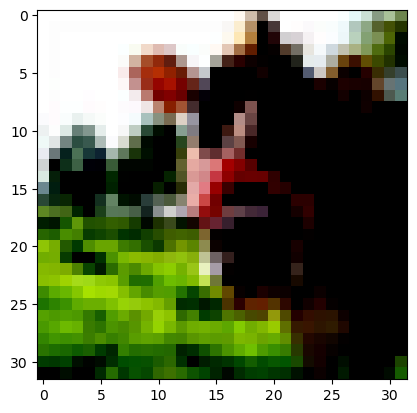

In [9]:
show_img(*train_dataset[0])

The resolution of these images are really bad but our CNN should have no problem in classifying these images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  keyboard


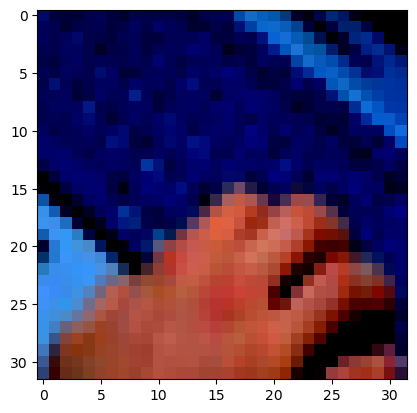

In [10]:
show_img(*train_dataset[10])

## Data Preperation - Training and Validation Data

In [11]:
BATCH_SIZE = 70
val_pct = 0.1

In [12]:
total_data = len(train_dataset)
val_size = int(total_data * val_pct)
train_size = total_data - val_size

In [13]:
random_seed = 6
torch.manual_seed(random_seed)

In [14]:
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [15]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE*2, num_workers=4, pin_memory=True)

/shared/centos7/classes_conda_envs/CS7150/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
def show_batch(dl, show_shape=False):
    for images, labels in dl:
        
        if show_shape:
            print(f"{images.shape=}\n{labels.shape=}")
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape=torch.Size([70, 3, 32, 32])
labels.shape=torch.Size([70])


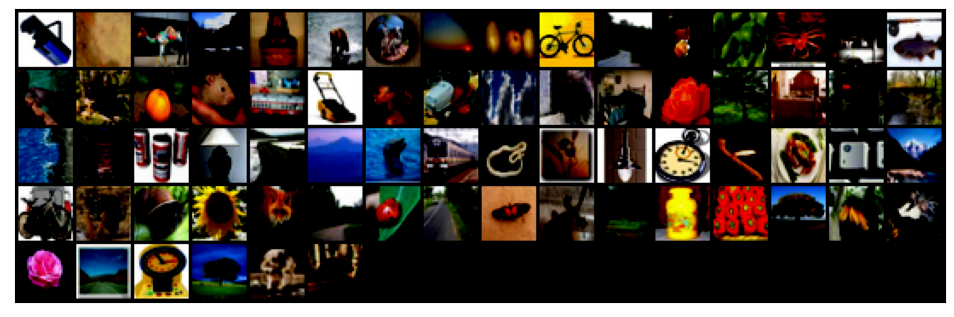

In [17]:
show_batch(train_dl, show_shape=True)

## Modelling

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
class ImageClassificationBase(nn.Module):
    _val_loss = 'val_loss'
    _val_acc = 'val_acc'
    
    def training_step(self, batch, to_device=True):
        """
        Perform one batch of training 
        """
        images, labels = batch
        if to_device:
            images = images.to(device)
            labels = labels.to(device)
        predictions = self(images)
        loss = F.cross_entropy(predictions, labels)
        return loss
        
    def validation_step(self, batch, to_device=True):
        """
        Perform validation of one batch
        """
        images, labels = batch
        if to_device:
            images = images.to(device)
            labels = labels.to(device)
        predictions = self(images)
        loss = F.cross_entropy(predictions, labels)
        acc = accuracy(predictions, labels)
        return {ImageClassificationBase._val_loss:loss.detach(), ImageClassificationBase._val_acc:acc}
    
    def validation_epoch_end(self, outputs):
        """
        Combine and find losses and accuracies for all batches in a single epoch
        """
        losses = [res[ImageClassificationBase._val_loss] for res in outputs]
        epoch_loss = torch.stack(losses).mean().item()
        
        acc = [res[ImageClassificationBase._val_acc] for res in outputs]
        epoch_acc = torch.stack(acc).mean().item()
        
        return {ImageClassificationBase._val_loss:epoch_loss, ImageClassificationBase._val_acc:epoch_acc}
        
    def epoch_verbose(self, epoch, result, print_every):
        """
        Print the accuracy and loss at the end of current epoch
        """
        if (epoch+1)%print_every==0:
            print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result[ImageClassificationBase._val_loss], result[ImageClassificationBase._val_acc]))
    
    def predict(self, batch, to_device=True):
        with torch.no_grad():
            return self.validation_step(batch, to_device)

In [20]:
class Cifar100CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),  # Add BatchNorm2d
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32),  # Depthwise convolution
            nn.Conv2d(32, 64, kernel_size=1),  # Pointwise convolution
            nn.BatchNorm2d(64),  # Add BatchNorm2d
            nn.ELU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Add BatchNorm2d
            nn.ELU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),  # Add BatchNorm2d
            nn.ELU(),
            nn.MaxPool2d(2, 2), # output: 128*7*7
            nn.Dropout(0.5),

            nn.Flatten(), 
            nn.Linear(128*7*7, 1024*2),
            nn.BatchNorm1d(1024*2),  # Add BatchNorm1d for Linear layer
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(1024*2, 512),
            nn.ELU(),
            nn.Dropout(0.25),
            nn.Linear(512, 100))

        
    def forward(self, xb):
        return self.network(xb)

In [21]:
model = Cifar100CnnModel().to(device)
model

Cifar100CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
    (4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ELU(alpha=1.0)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ELU(alpha=1.0)
    (15): MaxPool2d

In [22]:
best_model = model
min_val_loss = float('inf')
best_epoch = float('-inf')
overtraining = 0

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, print_every=1, save_best=True, tolerance=3):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    global best_model, min_val_loss, best_epoch, overtraining

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_verbose(epoch, result, print_every)
        history.append(result)
        
        if save_best:
            if min_val_loss>result['val_loss']:
                best_model = model.state_dict()
                best_epoch = epoch+1
                min_val_loss=result['val_loss']
                if overtraining>0:
                    overtraining-=1
            else:
                overtraining+=1
                
            if overtraining==tolerance:
                print('EARLY STOPPING')
                break
            
    print("Best Epoch - ", best_epoch)
    return history

In [23]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 1e-4

In [24]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [1], train_loss: 3.6953, val_loss: 3.2938, val_acc: 0.2173
Epoch [2], train_loss: 3.0944, val_loss: 3.0224, val_acc: 0.2758
Epoch [3], train_loss: 2.8022, val_loss: 2.7479, val_acc: 0.3205
Epoch [4], train_loss: 2.6076, val_loss: 2.5705, val_acc: 0.3594
Epoch [5], train_loss: 2.4770, val_loss: 2.4074, val_acc: 0.3877
Epoch [6], train_loss: 2.3724, val_loss: 2.3249, val_acc: 0.4050
Epoch [7], train_loss: 2.2732, val_loss: 2.2444, val_acc: 0.4377
Epoch [8], train_loss: 2.1957, val_loss: 2.1857, val_acc: 0.4409
Epoch [9], train_loss: 2.1270, val_loss: 2.1523, val_acc: 0.4445
Epoch [10], train_loss: 2.0681, val_loss: 2.0952, val_acc: 0.4533
Epoch [11], train_loss: 2.0015, val_loss: 2.0637, val_acc: 0.4598
Epoch [12], train_loss: 1.9476, val_loss: 2.0427, val_acc: 0.4712
Epoch [13], train_loss: 1.8835, val_loss: 1.9985, val_acc: 0.4818
Epoch [14], train_loss: 1.8432, val_loss: 1.9858, val_acc: 0.4860
Epoch [15], train_loss: 1.8000, val_loss: 1.9667, val_acc: 0.4890
Epoch [16], train_l

# Evaluating Training

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

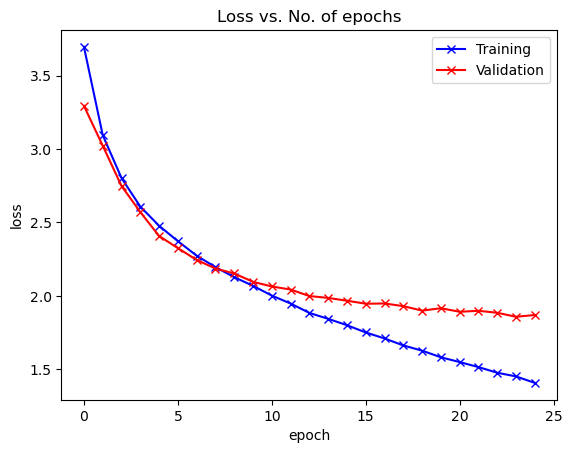

In [26]:
plot_losses(history)

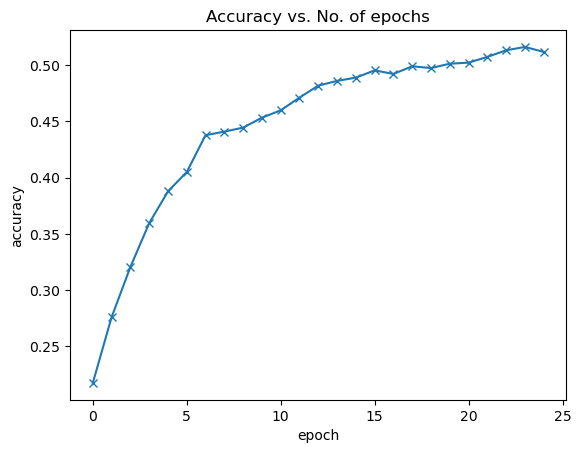

In [27]:
plot_accuracies(history)

# Saving the model

In [28]:
torch.save(best_model, 'cifar100-cnn.pth')

In [29]:
state_dict = torch.load("cifar100-cnn.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

# Testing the model

In [30]:
test_dl = DataLoader(eval_dataset, BATCH_SIZE*2, num_workers=4, pin_memory=True)

In [31]:
def show_predicted(model, image, label):
    with torch.no_grad():
        # Forward pass without gradient tracking
        pred = model(torch.unsqueeze(image, dim=0).to(device))

    max_index = torch.argmax(pred, dim=1).item()

    print("Label: ", train_dataset.classes[label], " Predicted: ", train_dataset.classes[max_index])
    plt.imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  mountain  Predicted:  mountain


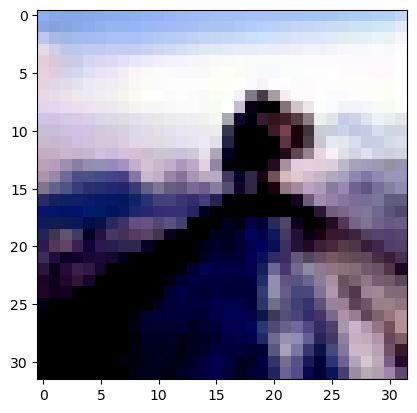

In [32]:
show_predicted(model, *eval_dataset[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  sea  Predicted:  television


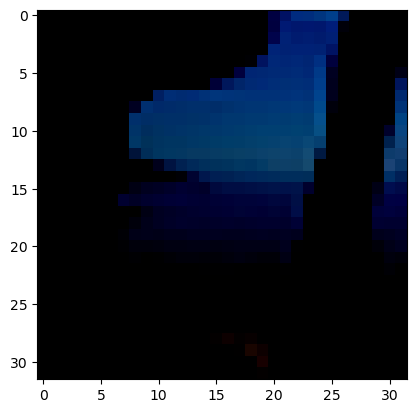

In [33]:
show_predicted(model, *eval_dataset[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  tulip  Predicted:  spider


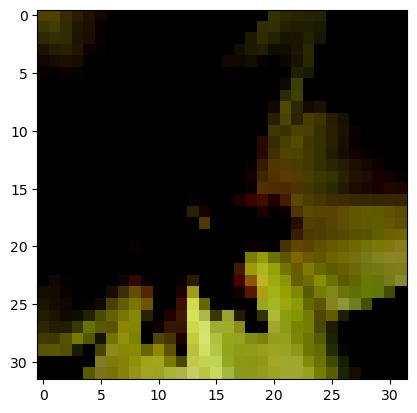

In [34]:
show_predicted(model, *eval_dataset[5])

In [35]:
tot_loss = 0
tot_acc = 0
model.eval()
for batch in test_dl:
    res = model.predict(batch)
    tot_loss += res['val_loss'].detach().item()
    tot_acc += res['val_acc'].detach().item()

print(f"Test Loss - {tot_loss/len(test_dl)} Test Accuracy - {tot_acc/len(test_dl)}")

Test Loss - 1.854078193505605 Test Accuracy - 0.5172949727210734
